# Load packages

In [1]:
from pathlib import Path
project_root = Path("/home/yangk/intership_2025_COSYS")

In [2]:
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import json
import numpy as np

In [3]:
import sys

sys.path.append(str(project_root / "resource/DexiNed"))
sys.path.append(str(project_root / "src"))

from model import DexiNed
from dataset import BIPEDv2, transforms

# Prepare

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epoch = 50
batch_size = 8
learning_rate = 1e-4
biped_dataset = BIPEDv2(
    project_root / "data/BIPEDv2/BIPED/edges/imgs/train/rgbr/real/",
    project_root / "data/BIPEDv2/BIPED/edges/edge_maps/train/rgbr/real/"
)
# test set
test_dataset = BIPEDv2(
    project_root / "data/BIPEDv2/BIPED/edges/imgs/test/rgbr/",
    project_root / "data/BIPEDv2/BIPED/edges/edge_maps/test/rgbr/"
)

model = DexiNed()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loader = DataLoader(biped_dataset, batch_size=8)
val_loader = DataLoader(test_dataset, batch_size=8)

print(device)

cuda


# Load

{'description': 'train with masked BECLoss like it in paper', 'num_epoch': 100, 'criterion': 'WeightedMaskedBCELoss', 'batch_size': 8, 'learning_rate': 5e-05}


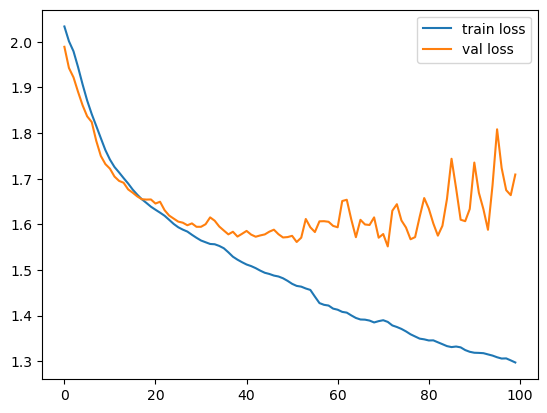

In [5]:
import matplotlib.pyplot as plt
# prefix = project_root / "data/checkpoints/torch_old_points"
# model_path = prefix / "cpt_e30_lr4.pth"
# log_path = prefix / "cpt_e30_lr4_log.json"
prefix = project_root / "data/checkpoints/torch_point03"
model_path = prefix / "model.pth"
log_path = prefix / "log.json"

model.load_state_dict(torch.load(str(model_path), weights_only=True))
# # load log
with open(str(log_path), 'r') as f:
    logging = json.load(f)
# # print the loss
print(logging['metadata'])
# Loss
plt.plot(logging['train_loss'], label="train loss")
plt.plot(logging['val_loss'], label="val loss")
# plt.xlabel("epoch")
# plt.title("loss evoluation")
plt.legend()
# plt.show()
plt.savefig(project_root/"loss.png")

# Result

In [6]:
from PIL import Image
# take one example
item= biped_dataset.__getitem__(6)
img, x, y = Image.open(item['image_path']).convert('RGB'), item['image_tensor'], item['edge_tensor']
# x = biped_dataset.transform(img)
# inference
model.eval()
with torch.no_grad():
    model.to(device)
    yhat = model(x.unsqueeze(0).to(device))[-1].squeeze()
    yhat = yhat.to('cpu')
    model.to('cpu')

In [60]:
import torch
import torch.nn.functional as F

def morphological_opening(img_tensor, kernel_size=3, iterations=1):
    """
    对灰度图像或批量灰度图像进行形态学开运算
    参数:
        img_tensor: (B, 1, H, W) 或 (1, H, W) 的 torch.Tensor，值范围 [0, 1] 或 [0, 255]
        kernel_size: 卷积核尺寸，建议为奇数，如3、5、7
        iterations: 开运算执行的次数，默认为1
    返回:
        开运算后的 torch.Tensor，形状与输入相同
    """
    # 确保输入是 4D Tensor
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)  # (1, 1, H, W)

    B, C, H, W = img_tensor.shape
    assert C == 1, "仅支持单通道灰度图像"

    # 构造结构元素（卷积核），全1矩阵
    kernel = torch.ones((1, 1, kernel_size, kernel_size), dtype=img_tensor.dtype, device=img_tensor.device)

    # 进行多次开运算
    out = img_tensor
    for _ in range(iterations):
        # 腐蚀（最小池化）
        eroded = -F.max_pool2d(-out, kernel_size, stride=1, padding=kernel_size//2)
        # 膨胀（最大池化）
        out = F.max_pool2d(eroded, kernel_size, stride=1, padding=kernel_size//2)

    return out.squeeze(0) if img_tensor.shape[0] == 1 else out

In [7]:
# NMS
edge_map = torch.where(torch.sigmoid(yhat)>0.65, 1., 0.)

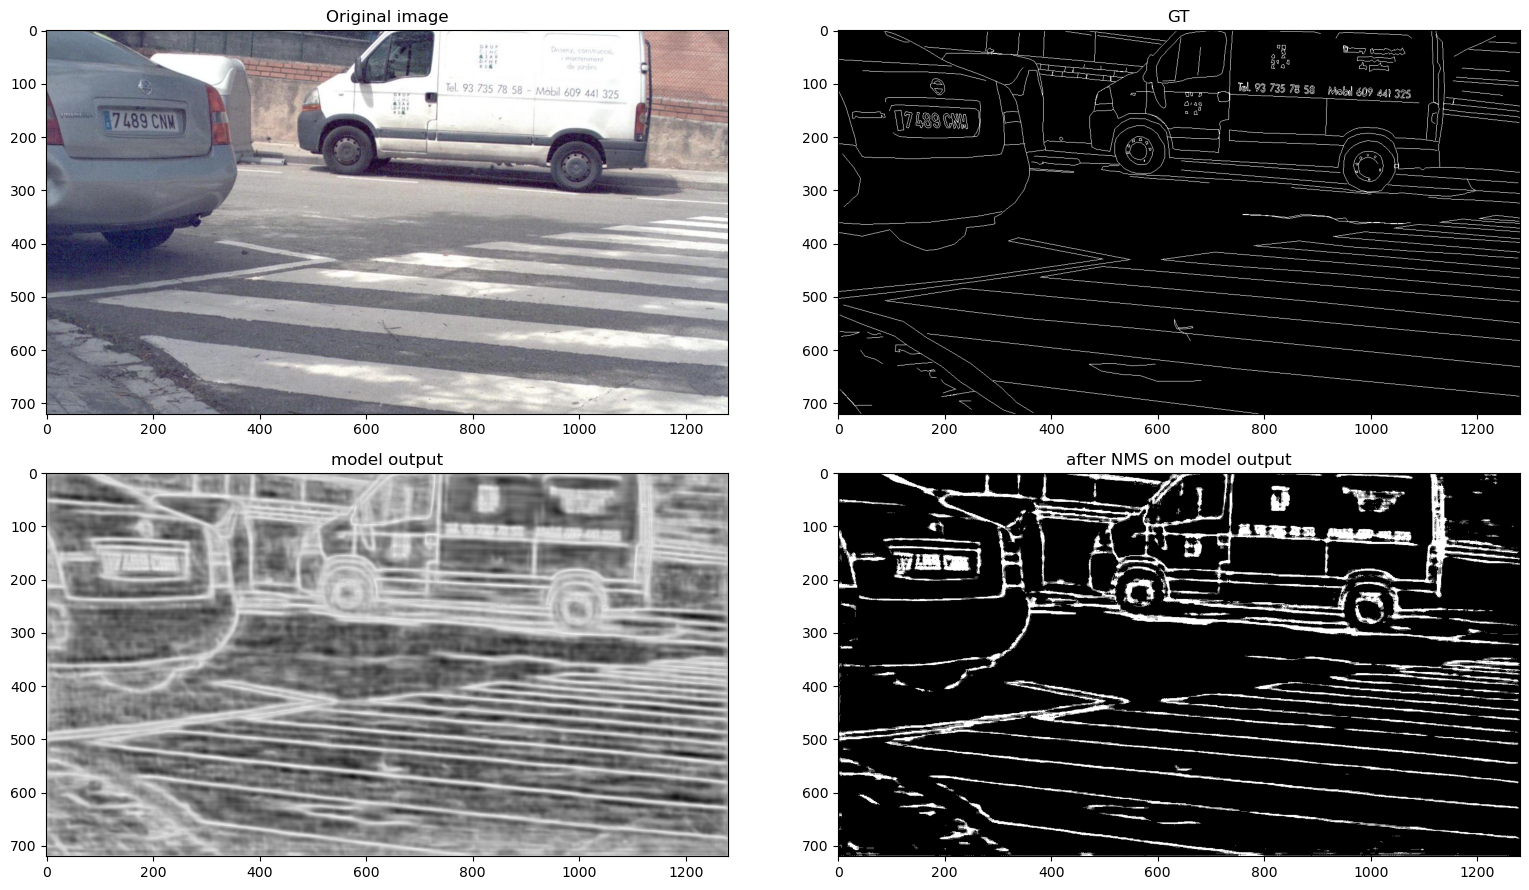

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cmap_type = "gray"

# display
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

# original image
axes[0,0].imshow(img)
axes[0,0].set_title("Original image")
# axes[0,1].axis('off')  # 不显示坐标轴

im = axes[0,1].imshow(y, cmap=cmap_type)
# fig.colorbar(im, ax=axes[0,0], shrink=0.7, location='bottom', extend='both')
axes[0,1].set_title("GT")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[1,0].imshow(yhat, cmap=cmap_type)
# axes[1,0].imshow(normalisation(yhat, 80), cmap="gray")
axes[1,0].set_title("model output")
# axes[1,1].axis('off')  # 不显示坐标轴

axes[1,1].imshow(edge_map, cmap="gray")
axes[1,1].set_title("after NMS on model output")
# axes[1,0].axis('off')  # 不显示坐标轴

plt.tight_layout()  # 自动调整子图间距
plt.show()